###### From SAV to LOVE

# HW №9

## Введение в обработку естественного языка
### Урок 9. Языковое моделирование
### Практическое задание

**Взять набор данных на ваше усмотрение (стихи/прозу) или что-то ещё для примера можно так же использовать прикреплённый Евгений Онегин**
<ol>
<li>поэкспериментировать с посимвольным подходом</li>
<li>проверить насколько изменится качество генерации текста при токенизации по словам</li>
</ol>

### Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import numpy as np

import os
import datetime

import re
import nltk
from nltk import word_tokenize

import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Download the dataset

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read the data

In [5]:
path_to_file = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/hagakure.txt'
# path_to_file = 'hagakure.txt'

In [6]:
text = open(path_to_file, 'rb').read().decode(encoding='Windows-1251')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 227034 characters


In [7]:
print(text[:250])

Цунэтомо Ямамото

Хагакурэ





Из Книги Первой

Хотя самурай должен прежде всего чтить Путь Самурая, не вызывает сомнений, что все мы небрежительны. Поэтому, если в наши дни спросить: «В чем подлинный смысл Пути Самурая?», лишь немногие ответят без 


### Prepare the text

## 1. поэкспериментировать с посимвольным подходом

In [10]:
text = re.sub('[^А-Яа-я0-9,.\t\n]+', ' ', text)

In [11]:
# Map unique characters to indices
vocab = sorted(set(text))
print ('There are {} unique characters'.format(len(vocab)))

There are 74 unique characters


In [12]:
char2idx = {c:i for i, c in enumerate(vocab)}
idx2char = np.array(vocab)

In [13]:
print('Vector:\n')
for char,_ in zip(char2idx, range(len(vocab))):
   print(' {:4s}: {:3d},'.format(repr(char), char2idx[char]))

Vector:

 '\t':   0,
 '\n':   1,
 ' ' :   2,
 ',' :   3,
 '.' :   4,
 '0' :   5,
 '1' :   6,
 '2' :   7,
 '3' :   8,
 '4' :   9,
 '5' :  10,
 '6' :  11,
 '7' :  12,
 '8' :  13,
 '9' :  14,
 'А' :  15,
 'Б' :  16,
 'В' :  17,
 'Г' :  18,
 'Д' :  19,
 'Е' :  20,
 'Ж' :  21,
 'З' :  22,
 'И' :  23,
 'К' :  24,
 'Л' :  25,
 'М' :  26,
 'Н' :  27,
 'О' :  28,
 'П' :  29,
 'Р' :  30,
 'С' :  31,
 'Т' :  32,
 'У' :  33,
 'Ф' :  34,
 'Х' :  35,
 'Ц' :  36,
 'Ч' :  37,
 'Ш' :  38,
 'Э' :  39,
 'Ю' :  40,
 'Я' :  41,
 'а' :  42,
 'б' :  43,
 'в' :  44,
 'г' :  45,
 'д' :  46,
 'е' :  47,
 'ж' :  48,
 'з' :  49,
 'и' :  50,
 'й' :  51,
 'к' :  52,
 'л' :  53,
 'м' :  54,
 'н' :  55,
 'о' :  56,
 'п' :  57,
 'р' :  58,
 'с' :  59,
 'т' :  60,
 'у' :  61,
 'ф' :  62,
 'х' :  63,
 'ц' :  64,
 'ч' :  65,
 'ш' :  66,
 'щ' :  67,
 'ъ' :  68,
 'ы' :  69,
 'ь' :  70,
 'э' :  71,
 'ю' :  72,
 'я' :  73,


In [14]:
text_as_int = np.array([char2idx[c] for c in text])
print ('{}\n mapped to integers:\n {}'.format(repr(text[:100]), text_as_int[:100]))

'Цунэтомо Ямамото\n\nХагакурэ\n\n\n\n\n\nИз Книги Первой\n\nХотя самурай должен прежде всего чтить Путь Самурая'
 mapped to integers:
 [36 61 55 71 60 56 54 56  2 41 54 42 54 56 60 56  1  1 35 42 45 42 52 61
 58 71  1  1  1  1  1  1 23 49  2 24 55 50 45 50  2 29 47 58 44 56 51  1
  1 35 56 60 73  2 59 42 54 61 58 42 51  2 46 56 53 48 47 55  2 57 58 47
 48 46 47  2 44 59 47 45 56  2 65 60 50 60 70  2 29 61 60 70  2 31 42 54
 61 58 42 73]


In [15]:
# Comfirm the shapes are what we expect:
print(text_as_int.shape)

(223835,)


### Build the model

In [16]:
batch_size = 64
buffer_size = 10000
embedding_dim = 256
seq_length = 100
examples_per_epoch = len(text)//seq_length
# lr = 0.001 # will use default for Adam optimizer
rnn_units = 1024
vocab_size = len(vocab)

In [17]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [18]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
print(dataset)

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>


In [19]:
# Print the first example input and target values:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'Цунэтомо Ямамото\n\nХагакурэ\n\n\n\n\n\nИз Книги Первой\n\nХотя самурай должен прежде всего чтить Путь Самурая'
Target data: 'унэтомо Ямамото\n\nХагакурэ\n\n\n\n\n\nИз Книги Первой\n\nХотя самурай должен прежде всего чтить Путь Самурая,'


In [20]:
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [21]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [22]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

### Run the model

In [23]:
# Check the output shape
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 74) # (batch_size, sequence_length, vocab_size)


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           18944     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          6297600   
_________________________________________________________________
dropout (Dropout)            (64, None, 1024)          0         
_________________________________________________________________
dense (Dense)                (64, None, 74)            75850     
Total params: 10,330,698
Trainable params: 10,330,698
Non-trainable params: 0
_________________________________________________________________


In [25]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

## Train the model

In [26]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# def accuracy(labels, logits):
#     return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
# example_batch_acc  = accuracy(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Loss:      ", example_batch_loss.numpy().mean())
# print("Accuracy:      ", example_batch_acc.numpy().mean())

Prediction shape:  (64, 100, 74)  # (batch_size, sequence_length, vocab_size)
Loss:       4.305231


In [27]:
optimizer = tf.keras.optimizers.Adam() 
model.compile(optimizer=optimizer, loss=loss)

### Configure checkpoints

In [28]:
checkpoint_dir = './checkpoints'+ datetime.datetime.now().strftime("_%Y.%m.%d-%H:%M:%S")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

In [29]:
epochs = 100

In [30]:
history = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback]) 

Epoch 1/100
34/34 [==============================] - 7s 132ms/step - loss: 3.9561
Epoch 2/100
34/34 [==============================] - 5s 135ms/step - loss: 3.0538
Epoch 3/100
34/34 [==============================] - 5s 138ms/step - loss: 2.6199
Epoch 4/100
34/34 [==============================] - 5s 140ms/step - loss: 2.4133
Epoch 5/100
34/34 [==============================] - 5s 142ms/step - loss: 2.2703
Epoch 6/100
34/34 [==============================] - 5s 142ms/step - loss: 2.1335
Epoch 7/100
34/34 [==============================] - 5s 141ms/step - loss: 1.9960
Epoch 8/100
34/34 [==============================] - 5s 140ms/step - loss: 1.8773
Epoch 9/100
34/34 [==============================] - 5s 138ms/step - loss: 1.7687
Epoch 10/100
34/34 [==============================] - 5s 136ms/step - loss: 1.6726
Epoch 11/100
34/34 [==============================] - 5s 135ms/step - loss: 1.5805
Epoch 12/100
34/34 [==============================] - 5s 133ms/step - loss: 1.5034
Epoch 13/100


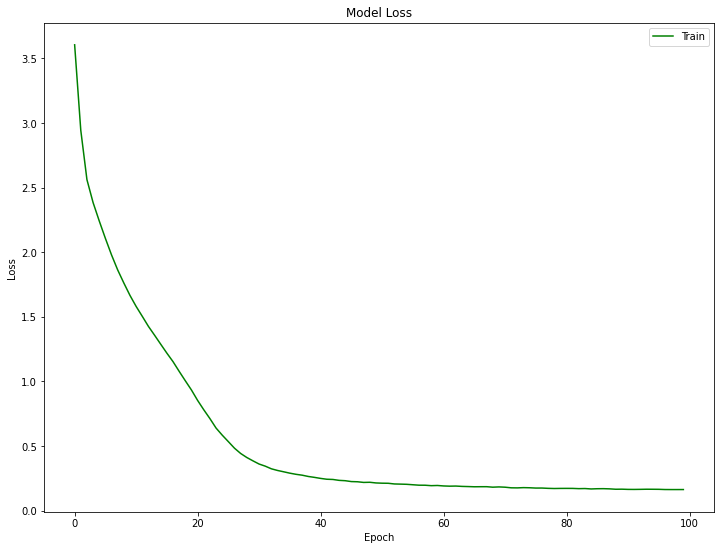

In [31]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'], 'g')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

## Generate text

In [32]:
tf.train.latest_checkpoint(checkpoint_dir)

'./checkpoints_2021.05.04-07:55:38/ckpt_100'

In [44]:
# !rm -rf checkpoints_2021.05.04-07:55:38

In [34]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            18944     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           6297600   
_________________________________________________________________
dropout_1 (Dropout)          (1, None, 1024)           0         
_________________________________________________________________
dense_1 (Dense)              (1, None, 74)             75850     
Total params: 10,330,698
Trainable params: 10,330,698
Non-trainable params: 0
_________________________________________________________________


In [36]:
def generate_text(model, start_string):
    
    print('Generating with seed: "' + start_string + '"')
    
    num_generate = 350

    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    
    temperature = 0.1

    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [37]:
print(generate_text(model, start_string=u"Подлинный самурай никогда не должен расслабляться и падать духом."))

Generating with seed: "Подлинный самурай никогда не должен расслабляться и падать духом."
Подлинный самурай никогда не должен расслабляться и падать духом. Нужно стать безумным и одержимым. Ведь если на Пути Самурая ты будешь благоразумным, ты быстро одолел их. Хотя Канносукэ тогда исполнилось пятнадцать лет. Когда ему сообщили о своем клане, с ним нужно говорить очень строго, были справится со своей обязанностью .


 

Во времена господина Кацусигэ были слуги, которые, будь они изучать и собраться с


## 2. проверить насколько изменится качество генерации текста при токенизации по словам

### Prepare the text

In [78]:
word_tokens = word_tokenize(text)
word_vocab = sorted(set(word_tokens))
print ('There are {} unique words'.format(len(word_vocab)))

idx2word = np.array(word_vocab)
word2idx = {w: i for i, w in enumerate(word_vocab)}

There are 9093 unique words


In [79]:
text_as_int = np.array([word2idx[w] for w in word_tokens])

In [80]:
word_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = word_dataset.batch(seq_length+1, drop_remainder=True)
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
    print('Target data:', repr(' '.join(idx2word[target_example.numpy()])))

Input data:  'Цунэтомо Ямамото Хагакурэ Из Книги Первой Хотя самурай должен прежде всего чтить Путь Самурая , не вызывает сомнений , что все мы небрежительны . Поэтому , если в наши дни спросить В чем подлинный смысл Пути Самурая , лишь немногие ответят без промедления . А все потому , что никто заранее не готовит себя к ответу на такие вопросы . Это свидетельствует о том , что люди забывают о Пути . Небрежение опасно . Я постиг , что Путь Самурая это смерть . В ситуации или или без колебаний выбирай смерть . Это нетрудно . Исполнись решимости и действуй .'
Target data: 'Ямамото Хагакурэ Из Книги Первой Хотя самурай должен прежде всего чтить Путь Самурая , не вызывает сомнений , что все мы небрежительны . Поэтому , если в наши дни спросить В чем подлинный смысл Пути Самурая , лишь немногие ответят без промедления . А все потому , что никто заранее не готовит себя к ответу на такие вопросы . Это свидетельствует о том , что люди забывают о Пути . Небрежение опасно . Я постиг , что Путь С

In [81]:
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

### Build The Model

In [82]:
model = build_model(
    vocab_size = len(word_vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

### Run the model

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (64, None, 256)           2327808   
_________________________________________________________________
gru_8 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
gru_9 (GRU)                  (64, None, 1024)          6297600   
_________________________________________________________________
dropout_4 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
dense_4 (Dense)              (64, None, 9093)          9320325   
Total params: 21,884,037
Trainable params: 21,884,037
Non-trainable params: 0
_________________________________________________________________


### Configure checkpoints

In [84]:
checkpoint_dir = './checkpoints'+ datetime.datetime.now().strftime("_%Y.%m.%d-%H:%M:%S")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Train the model

In [85]:
optimizer = tf.keras.optimizers.Adam() 
model.compile(optimizer=optimizer, loss=loss)

In [95]:
epochs = 110 # 350

In [96]:
history_word = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback]) 

Epoch 1/110
6/6 [==============================] - 2s 242ms/step - loss: 0.4956
Epoch 2/110
6/6 [==============================] - 2s 245ms/step - loss: 0.4699
Epoch 3/110
6/6 [==============================] - 2s 246ms/step - loss: 0.4620
Epoch 4/110
6/6 [==============================] - 2s 245ms/step - loss: 0.4398
Epoch 5/110
6/6 [==============================] - 2s 247ms/step - loss: 0.4280
Epoch 6/110
6/6 [==============================] - 2s 246ms/step - loss: 0.4161
Epoch 7/110
6/6 [==============================] - 2s 248ms/step - loss: 0.3960
Epoch 8/110
6/6 [==============================] - 2s 247ms/step - loss: 0.3861
Epoch 9/110
6/6 [==============================] - 2s 248ms/step - loss: 0.3729
Epoch 10/110
6/6 [==============================] - 2s 247ms/step - loss: 0.3615
Epoch 11/110
6/6 [==============================] - 2s 249ms/step - loss: 0.3508
Epoch 12/110
6/6 [==============================] - 2s 250ms/step - loss: 0.3352
Epoch 13/110
6/6 [===================

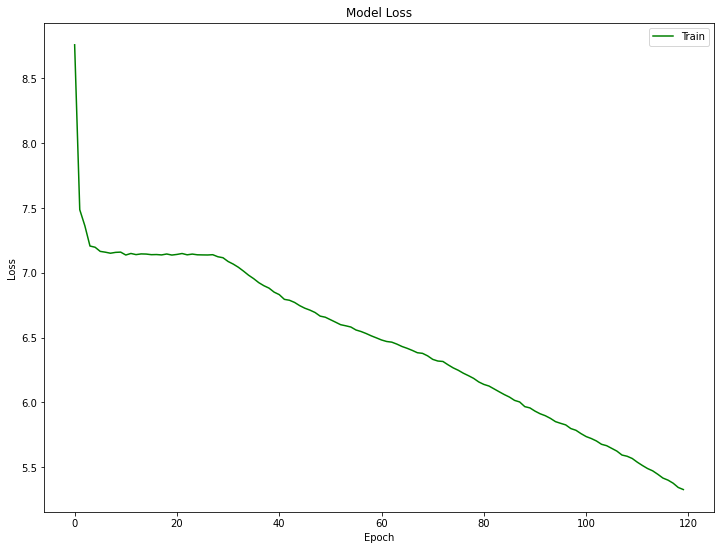

In [88]:
plt.figure(figsize=(12, 9))
plt.plot(history_word.history['loss'], 'g')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

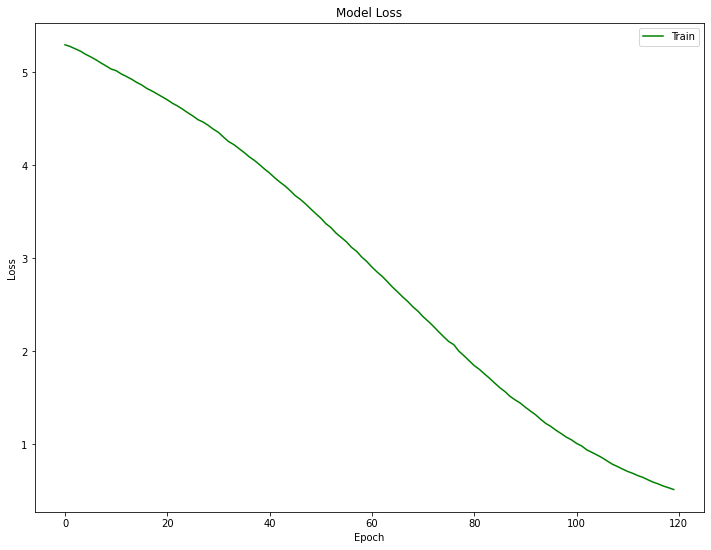

In [92]:
plt.figure(figsize=(12, 9))
plt.plot(history_word.history['loss'], 'g')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

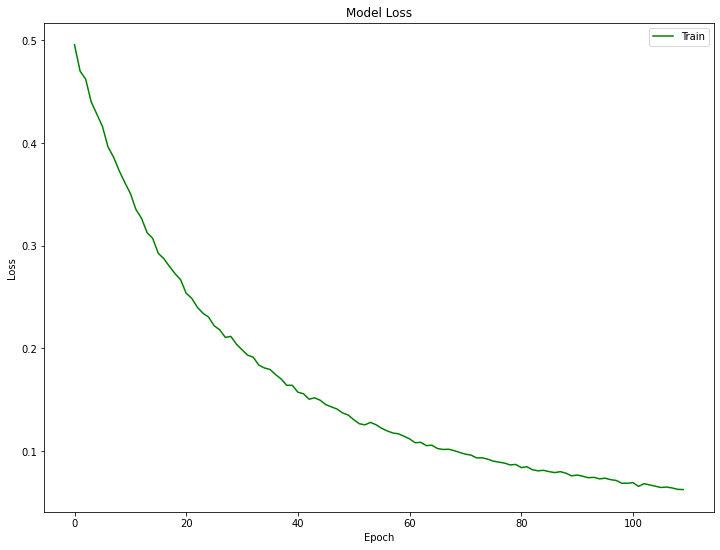

In [97]:
plt.figure(figsize=(12, 9))
plt.plot(history_word.history['loss'], 'g')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Generate text

In [98]:
tf.train.latest_checkpoint(checkpoint_dir)

'./checkpoints_2021.05.04-09:00:21/ckpt_110'

In [143]:
# !rm -rf checkpoints_2021.05.04-09:00:21

In [100]:
model = build_model(
    vocab_size=len(word_vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [119]:
def generate_text(model, start_string):
    
    print('Generating with seed: "' + start_string + '"')   
    
    num_generate = 100

    input_eval = [word2idx[s] for s in [start_string]]
    input_eval = tf.expand_dims(input_eval, 0)
    
    temperature = 1.5

    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature

        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id])

    return (start_string + ' '.join(text_generated))

In [120]:
print(generate_text(model, start_string=u"Самурай"))

Generating with seed: "Самурай"
Самурайбуддийского старшими вывод стужу получит Хамада видны общении году родительском мерам безгранична происшествии заложил тодомэ чрезмерно обесцениваются Оказалось выступлений чрезмерной всего чернил опрометчивые Сделать лидер Достаточно различие перекладине чернил секты проломил движение 24 Токаййо родительском оглянулся Правила чайной период процесс провинившемуся седьмого взрослого цвета преданным второго четырнадцатый последними ги сбил заменено покойником закрывали устойчиво стремлением перенимают азарт принятии годовщину Тодороки столицы этап охоту княжество разницу церемонии востоку Постепенное Кога принципы происходящем корейском сопровождал решено Эгути братьев вызову вдохновителем брат основывается Смысл Порой церемонии оставляет дни слабоумии пребывает встретила пятый реакцией отказу Тих Составитель добрых состоянием консерватизмом изречении Мидзуно шахматы отставка


## Additionally

### Reading data

In [121]:
import collections

In [128]:
def preprocess_text(text):
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('^',' ')
    text = text.replace('_',' ')
    text = text.replace('{',' ')
    text = text.replace('\xa0',' ')
    text = text.replace('«',' ')
    text = text.replace('»',' ')
    text = text.replace('—',' ')
    text = text.replace('“',' ')
    text = text.replace('„',' ')
    text = text.replace('…',' ')
    text = text.replace('/',' ')
    text = text.replace('?',' ')

    return text

In [129]:
def read_data(filename):
  # Extract the first file enclosed in a zip file as a list of words
    with open(filename, 'rb') as f:
        data = []
        file_string = f.read().decode(encoding='Windows-1251')
        file_string = preprocess_text(file_string)
        file_string = file_string.split(' ')
        data.extend(file_string)
    return data

In [130]:
# words = open(path_to_file, 'rb').read().decode(encoding='Windows-1251')
words = read_data(path_to_file)

In [131]:
print('Data size %d' % len(words))
print('Example words (start): ', words[:10])
print('Example words (end): ', words[-10:])

Data size 34963
Example words (start):  ['Цунэтомо', 'Ямамото\n\nХагакурэ\n\n\n\n\n\nИз', 'Книги', 'Первой\n\nХотя', 'самурай', 'должен', 'прежде', 'всего', 'чтить', 'Путь']
Example words (end):  ['написания', 'книги', 'отошел', 'от', 'жизни', 'самурая', 'и', 'стал', 'буддистским', 'монахом.\n\n']


In [132]:
vocabulary_size = 0
def build_dataset(words):
    global vocabulary_size

    count = [['UNK', -1]]
    # Gets words sorted by frequency
    count.extend(collections.Counter(words).most_common())
    dictionary = dict()

    # Create an ID for each unique word
    for word, c in count:
        if c<10:
            continue
        dictionary[word] = len(dictionary)
        vocabulary_size += 1
    
    data = list()
    unk_count = 0
  
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  
            unk_count = unk_count + 1
        data.append(index)
    
    count[0][1] = unk_count
  
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    
    return data, count, dictionary, reverse_dictionary

In [133]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:25])
print('Sample data', data[:10])
print('Vocabulary size: ', vocabulary_size)

Most common words (+UNK) [['UNK', 17488], ('', 1354), ('и', 1004), ('в', 857), ('не', 661), ('что', 487), ('он', 386), ('на', 355), ('с', 280), ('*', 279), ('его', 242), ('к', 238), ('ты', 201), ('о', 185), ('человек', 170), ('если', 167), ('это', 163), ('был', 156), ('Если', 151), ('я', 150), ('из', 144), ('когда', 142), ('как', 124), ('или', 120), ('В', 118)]
Sample data [271, 0, 292, 0, 202, 32, 340, 94, 0, 181]
Vocabulary size:  375


### Execute the training

### Generating data

In [134]:
data_index = 0

def generate_batch(batch_size, window_size):
    global data_index 
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span defines the total window size
    span = 2 * window_size + 1 
    
    # The buffer holds the data contained within the span
    queue = collections.deque(maxlen=span)
  
    # Fill the buffer and update the data_index
    for _ in range(span):
        queue.append(data[data_index])
        data_index = (data_index + 1) % len(data)
  

    for i in range(batch_size // (2*window_size)):
        k=0
        # Avoid the target word itself as a prediction
        for j in list(range(window_size))+list(range(window_size+1, 2*window_size+1)):
            batch[i * (2*window_size) + k] = queue[window_size]
            labels[i * (2*window_size) + k, 0] = queue[j]
            k += 1 
    
        # Everytime we read num_samples data points, update the queue
        queue.append(data[data_index])
    
        # If end is reached, circle back to the beginning
        data_index = (data_index + np.random.randint(window_size)) % len(data)
    
    return batch, labels

In [135]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch, labels = generate_batch(batch_size=8, window_size=2)
print('\nwith window_size = %d:' %2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['Цунэтомо', '', 'Книги', '', 'самурай', 'должен', 'прежде', 'всего']

with window_size = 2:
    batch: ['Книги', 'Книги', 'Книги', 'Книги', '', '', '', '']
    labels: ['Цунэтомо', '', '', 'самурай', '', 'Книги', 'самурай', 'должен']


### Defining the model

In [136]:
batch_size = 64 
embedding_size = 256 
window_size = 4 

num_sampled = 32 # Number of negative examples to sample.

In [137]:
import math
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

################################################
#            Model variables                   #
################################################

# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Neural network weights and biases
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.1 / math.sqrt(embedding_size))
)
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],-0.01,0.01))

# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)
#embed = tf.nn.dropout(embed, keep_prob=0.8)
################################################
#            Computes loss                     #
################################################
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

################################################
#            Optimization                      #
################################################
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

################################################
#            For evaluation                    #
################################################
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

Instructions for updating:
non-resource variables are not supported in the long term


### Running skip-gram

In [138]:
num_steps = 250001

session = tf.InteractiveSession()

# Initialize the variables in the graph
tf.global_variables_initializer().run()
print('Initialized')
average_loss = 0

for step in range(num_steps):

    # Generate a single batch of data
    batch_data, batch_labels = generate_batch(
        batch_size, window_size)

    # Optimize the embedding layer and neural network
    # compute loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    # Update the average loss variable
    average_loss += l

    if (step+1) % 5000 == 0:
        if step > 0:
            average_loss = average_loss / 5000

        print('Average loss at step %d: %f' % (step+1, average_loss))
        average_loss = 0

sg_embeddings = normalized_embeddings.eval()
session.close()

Initialized
Average loss at step 5000: 2.446091
Average loss at step 10000: 2.227322
Average loss at step 15000: 2.218727
Average loss at step 20000: 2.203397
Average loss at step 25000: 2.211762
Average loss at step 30000: 2.190263
Average loss at step 35000: 2.188664
Average loss at step 40000: 2.183360
Average loss at step 45000: 2.177798
Average loss at step 50000: 2.185136
Average loss at step 55000: 2.177565
Average loss at step 60000: 2.179966
Average loss at step 65000: 2.179588
Average loss at step 70000: 2.175547
Average loss at step 75000: 2.175637
Average loss at step 80000: 2.169622
Average loss at step 85000: 2.178236
Average loss at step 90000: 2.164476
Average loss at step 95000: 2.175676
Average loss at step 100000: 2.170635
Average loss at step 105000: 2.166788
Average loss at step 110000: 2.162180
Average loss at step 115000: 2.179966
Average loss at step 120000: 2.165569
Average loss at step 125000: 2.169197
Average loss at step 130000: 2.169995
Average loss at step

### Visualizing word vectors

In [139]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(sg_embeddings)

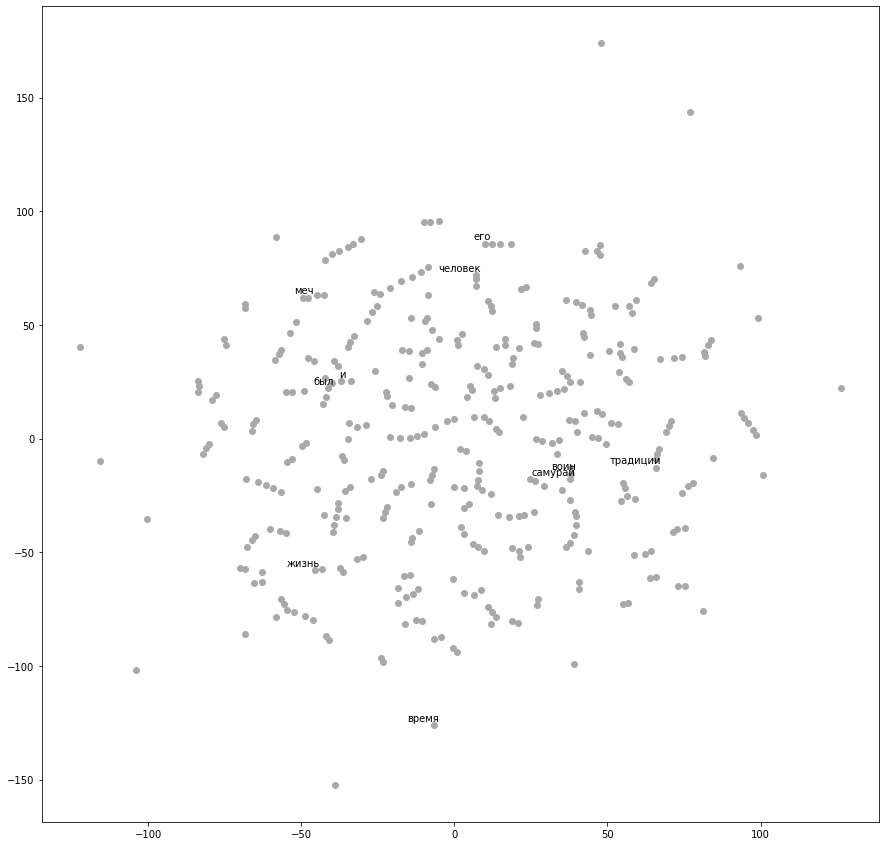

In [142]:
from matplotlib import pylab

selected_words = ['воин', 'был', 'его', 'и', 'путь', 'самурай', 'хагакурэ', 'традиции', 'человек', 'победа', 'меч', 'жизнь', 'время', 'смерть', 'сэппуку', 'преданность', 'сострадание']

words = [reverse_dictionary[i] for i in np.arange(vocabulary_size)]

pylab.figure(figsize=(15, 15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c='darkgray')   
    if label in selected_words:
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)
        
pylab.show()